# 🏠 Delhi House Price Prediction
###  Machine Learning Project

---

**Objective:** To build and evaluate machine learning regression models that predict house prices in Delhi based on key property features such as area, BHK count, locality, furnishing status, and more.

**Dataset:** MagicBricks Delhi Housing 
  DataSet Link: https://www.kaggle.com/code/fibyehab/delhi-house-price/input

---

### 📋 Data Dictionary

| Column | Description |
|--------|-------------|
| Area | Area of the house in square feet |
| BHK | Number of bedrooms |
| Bathroom | Number of bathrooms |
| Furnishing | Furnishing status (Furnished / Semi-Furnished / Unfurnished) |
| Locality | Locality of the house in Delhi |
| Parking | Number of parking spaces available |
| Price | Price of the house in INR (Target Variable) |
| Status | Property status — Ready to Move / Under Construction |
| Transaction | New Property or Resale |
| Type | Type of property — Builder Floor / Apartment |
| Per_Sqft | Price per square foot |

---

### 🔄 Project Pipeline
1. Data Loading & Exploration
2. Data Preprocessing
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Model Building & Hyperparameter Tuning
6. Model Evaluation & Comparison
7. Feature Importance & Explainability
8. Residual / Error Analysis
9. Predict on Custom Input
10. Conclusion

---
## 📦 1. Import Libraries

In [5]:
# Core libraries
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Set global plot style
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams.update({
    'figure.dpi': 120,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.titleweight': 'bold'
})

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

print('✅ All libraries imported successfully!')

✅ All libraries imported successfully!


---
## 📂 2. Load & Explore the Dataset

In [8]:
# Load dataset
os.chdir('C:\\Users\\user\\OneDrive\\Attachments\\Desktop\\DataSets')
df = pd.read_csv('MagicBricks.csv')

print(f'Dataset Shape: {df.shape}')
df.head()

Dataset Shape: (1259, 11)


,Area,BHK,Bathroom,Furnishing,Locality,Parking,Price,Status,Transaction,Type,Per_Sqft
0,800.0,3,2.0,Semi-Furnished,Rohini Sector 25,1.0,6500000,Ready_to_move,New_Property,Builder_Floor,NaN
1,750.0,2,2.0,Semi-Furnished,"J R Designers Floors, Rohini Sector 24",1.0,5000000,Ready_to_move,New_Property,Apartment,6667.0
2,950.0,2,2.0,Furnished,"Citizen Apartment, Rohini Sector 13",1.0,15500000,Ready_to_move,Resale,Apartment,6667.0
3,600.0,2,2.0,Semi-Furnished,Rohini Sector 24,1.0,4200000,Ready_to_move,Resale,Builder_Floor,6667.0
4,650.0,2,2.0,Semi-Furnished,Rohini Sector 24 carpet area 650 sqft status R...,1.0,6200000,Ready_to_move,New_Property,Builder_Floor,6667.0


In [9]:
# Basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Area         1259 non-null   float64
 1   BHK          1259 non-null   int64  
 2   Bathroom     1257 non-null   float64
 3   Furnishing   1254 non-null   object 
 4   Locality     1259 non-null   object 
 5   Parking      1226 non-null   float64
 6   Price        1259 non-null   int64  
 7   Status       1259 non-null   object 
 8   Transaction  1259 non-null   object 
 9   Type         1254 non-null   object 
 10  Per_Sqft     1018 non-null   float64
dtypes: float64(4), int64(2), object(5)
memory usage: 108.3+ KB


In [10]:
# Descriptive statistics
df.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
Area,1259.000000,1466.452724,1568.055040,28.000000,800.000000,1200.000000,1700.000000,24300.000000
BHK,1259.000000,2.796664,0.954425,1.000000,2.000000,3.000000,3.000000,10.000000
Bathroom,1257.000000,2.556086,1.042220,1.000000,2.000000,2.000000,3.000000,7.000000
Parking,1226.000000,1.935563,6.279212,1.000000,1.000000,1.000000,2.000000,114.000000
Price,1259.000000,21306703.733122,25601154.525780,1000000.000000,5700000.000000,14200000.000000,25500000.000000,240000000.000000
Per_Sqft,1018.000000,15690.136542,21134.738568,1259.000000,6364.000000,11291.500000,18000.000000,183333.000000


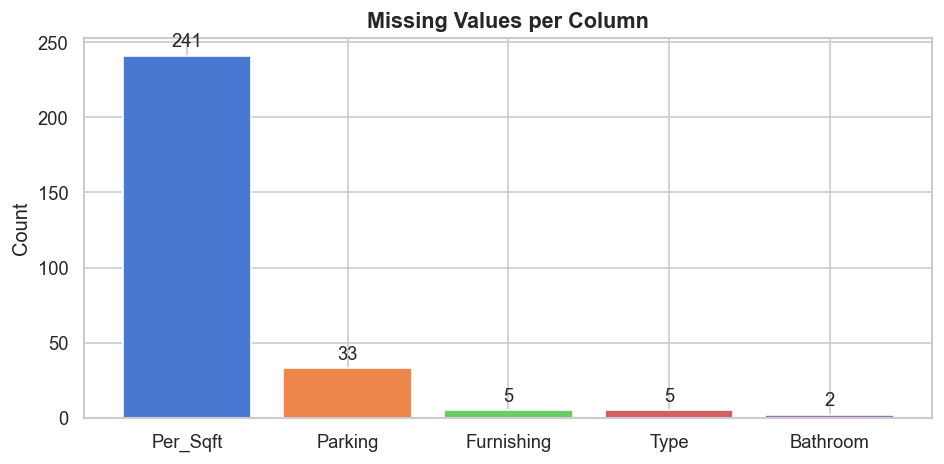


Total missing values: 286


In [11]:
# Check for missing values — visualized
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(missing.index, missing.values, color=sns.color_palette('muted', len(missing)))
ax.bar_label(bars, fmt='%d', padding=3)
ax.set_title('Missing Values per Column')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

print(f'\nTotal missing values: {df.isnull().sum().sum()}')

---
## 🧹 3. Data Preprocessing

In [12]:
# --- Fix 1: Per_Sqft — calculate from Price/Area where missing ---
df['Per_Sqft'] = df['Per_Sqft'].fillna(df['Price'] / df['Area'])

# --- Fix 2: Fill mode for categorical/discrete columns ---
for col in ['Parking', 'Bathroom', 'Furnishing', 'Type']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# --- Fix 3: Correct type casting (was missing inplace assignment) ---
df['Parking'] = df['Parking'].astype('int64')
df['Bathroom'] = df['Bathroom'].astype('int64')

print('✅ Missing values handled.')
print(f'Remaining nulls: {df.isnull().sum().sum()}')

✅ Missing values handled.
Remaining nulls: 0


In [13]:
# --- Add derived feature: Area in Sq. Yards ---
df['Area_Yards'] = df['Area'] / 9

# --- Locality Grouping (top 10 + Other) ---
def grp_local(locality):
    locality = locality.lower()
    mapping = {
        'rohini': 'Rohini Sector',
        'dwarka': 'Dwarka Sector',
        'shahdara': 'Shahdara',
        'vasant': 'Vasant Kunj',
        'paschim': 'Paschim Vihar',
        'alaknanda': 'Alaknanda',
        'vasundhar': 'Vasundhara Enclave',
        'punjabi': 'Punjabi Bagh',
        'kalkaji': 'Kalkaji',
        'lajpat': 'Lajpat Nagar'
    }
    for key, label in mapping.items():
        if key in locality:
            return label
    return 'Other'

df['Locality'] = df['Locality'].apply(grp_local)

print('Locality distribution:')
print(df['Locality'].value_counts())

Locality distribution:
Locality
Other                 716
Lajpat Nagar           90
Dwarka Sector          87
Rohini Sector          75
Shahdara               75
Alaknanda              58
Vasant Kunj            35
Kalkaji                32
Punjabi Bagh           31
Paschim Vihar          30
Vasundhara Enclave     30
Name: count, dtype: int64


In [14]:
# --- Outlier Removal using Z-Score ---
from scipy import stats

num_cols = df.select_dtypes(exclude='object').columns
z = np.abs(stats.zscore(df[num_cols]))
before = len(df)
df = df[(z < 3).all(axis=1)]
after = len(df)

print(f'Rows before outlier removal: {before}')
print(f'Rows after  outlier removal: {after}')
print(f'Outliers removed: {before - after}')

Rows before outlier removal: 1259
Rows after  outlier removal: 1189
Outliers removed: 70


---
## 📊 4. Exploratory Data Analysis (EDA)

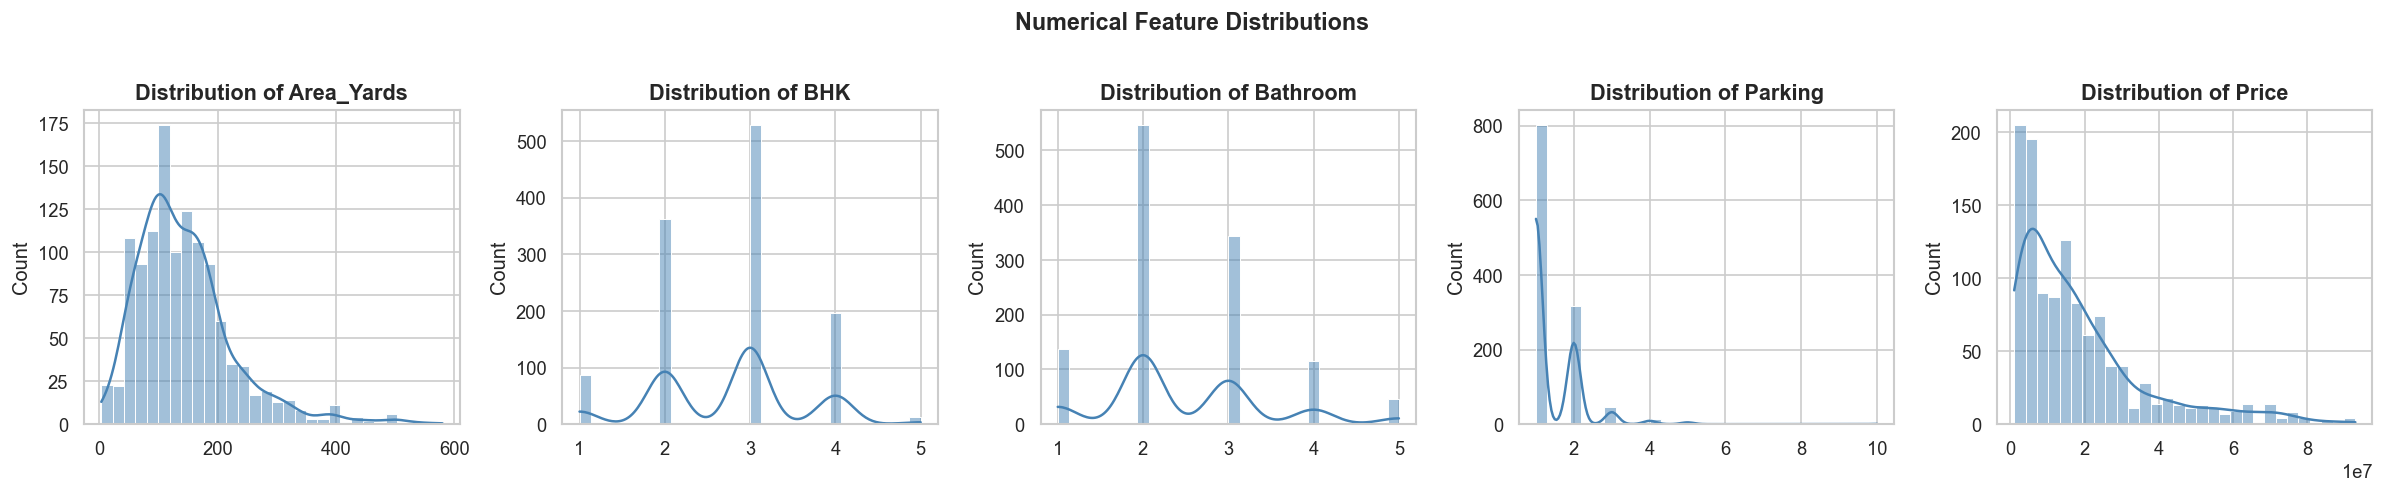

In [15]:
# --- Distribution of Numerical Features ---
num_features = ['Area_Yards', 'BHK', 'Bathroom', 'Parking', 'Price']

fig, axes = plt.subplots(1, len(num_features), figsize=(20, 4))
for ax, col in zip(axes, num_features):
    sns.histplot(df[col], kde=True, ax=ax, color='steelblue', bins=30)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('')

plt.suptitle('Numerical Feature Distributions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

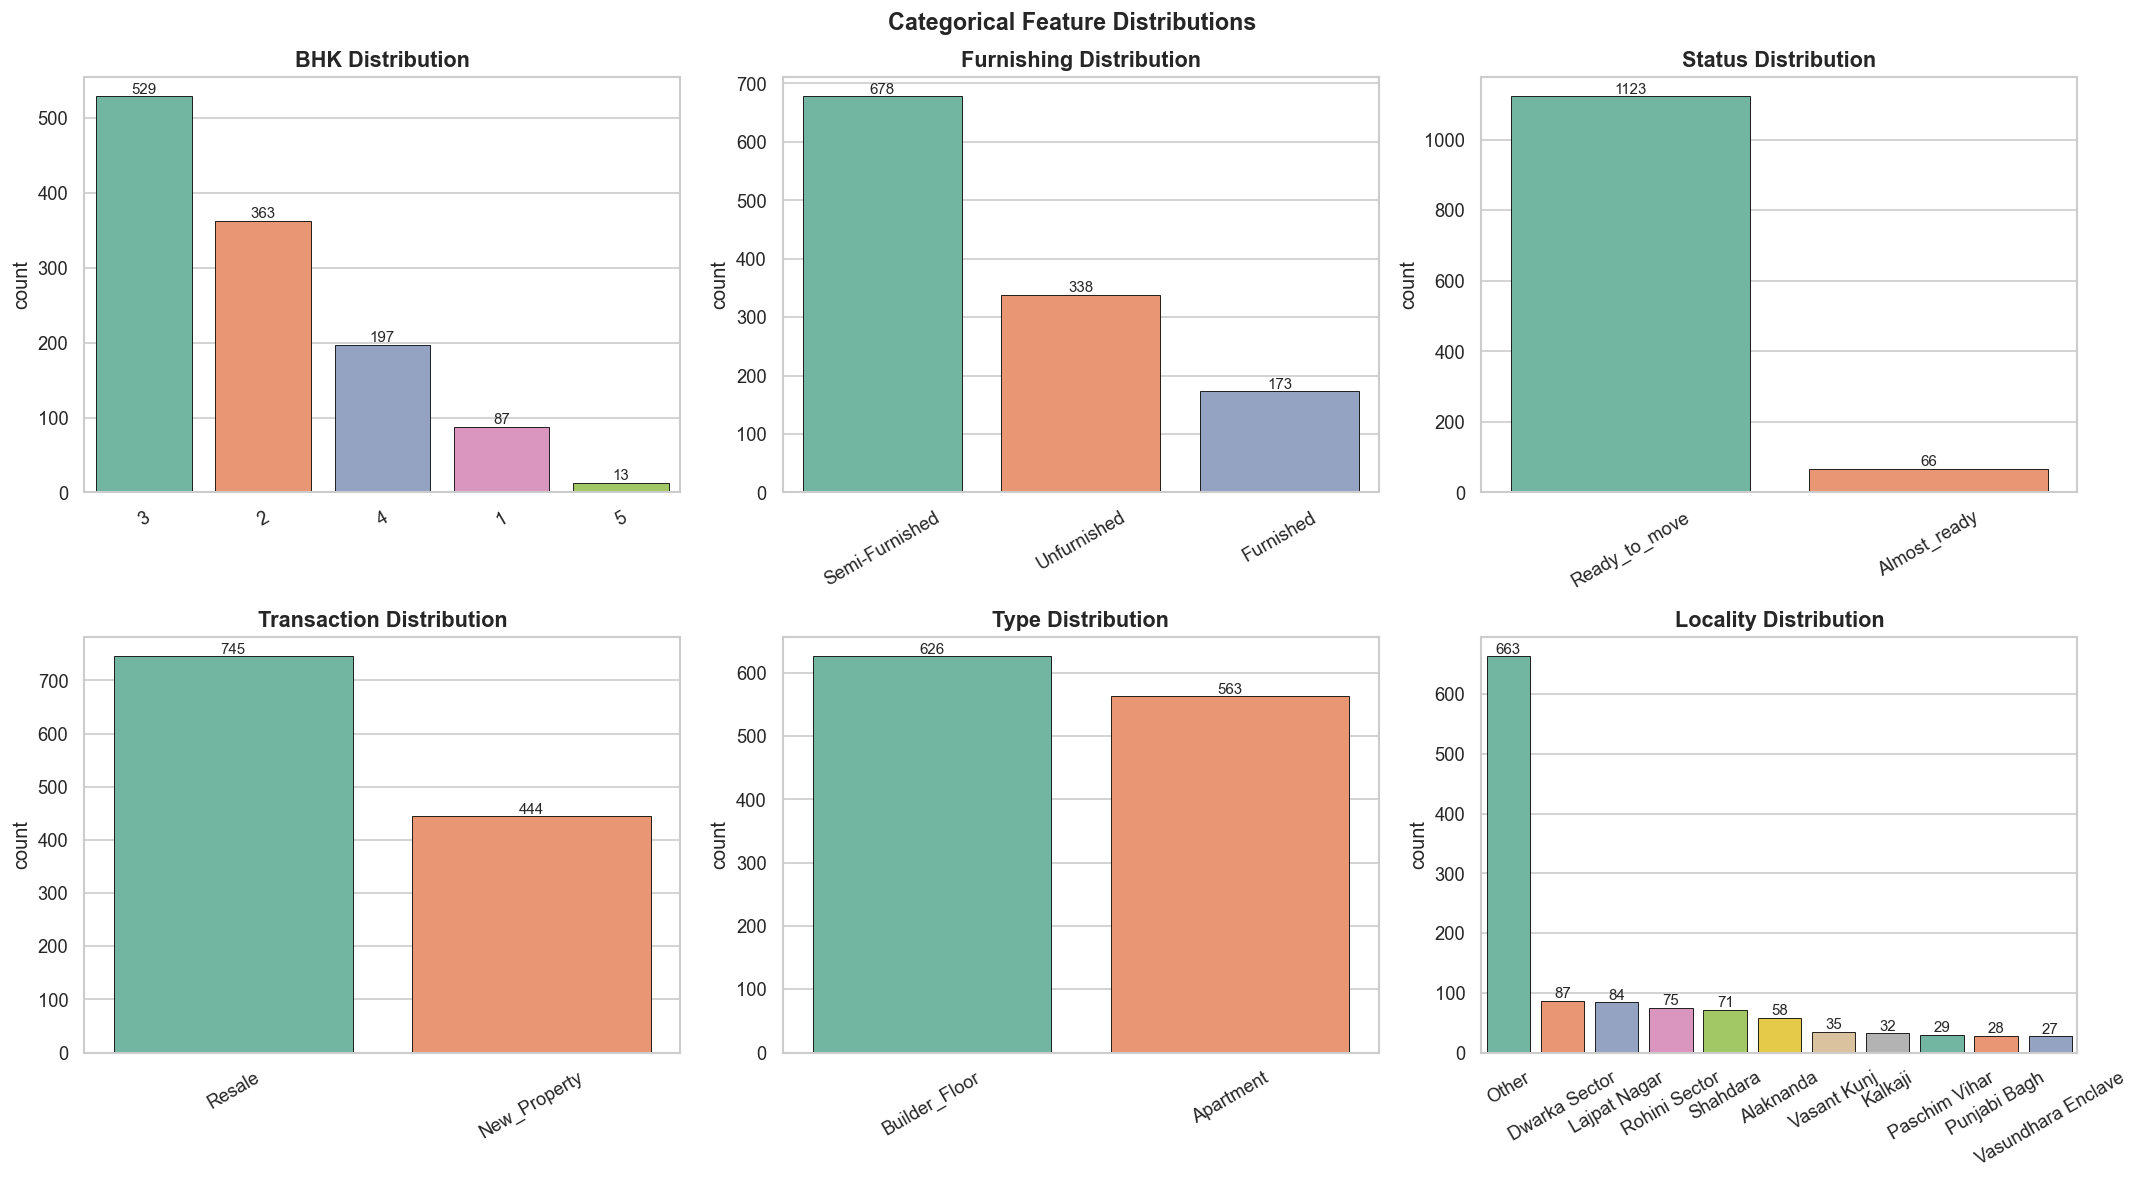

In [16]:
# --- Categorical Feature Count Plots ---
cat_features = ['BHK', 'Furnishing', 'Status', 'Transaction', 'Type', 'Locality']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(cat_features):
    order = df[col].value_counts().index
    sns.countplot(x=col, data=df, ax=axes[i], order=order,
                  palette='Set2', edgecolor='black', linewidth=0.5)
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=30)
    for bar in axes[i].patches:
        axes[i].annotate(f'{int(bar.get_height())}',
                         (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                         ha='center', va='bottom', fontsize=9)

plt.suptitle('Categorical Feature Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

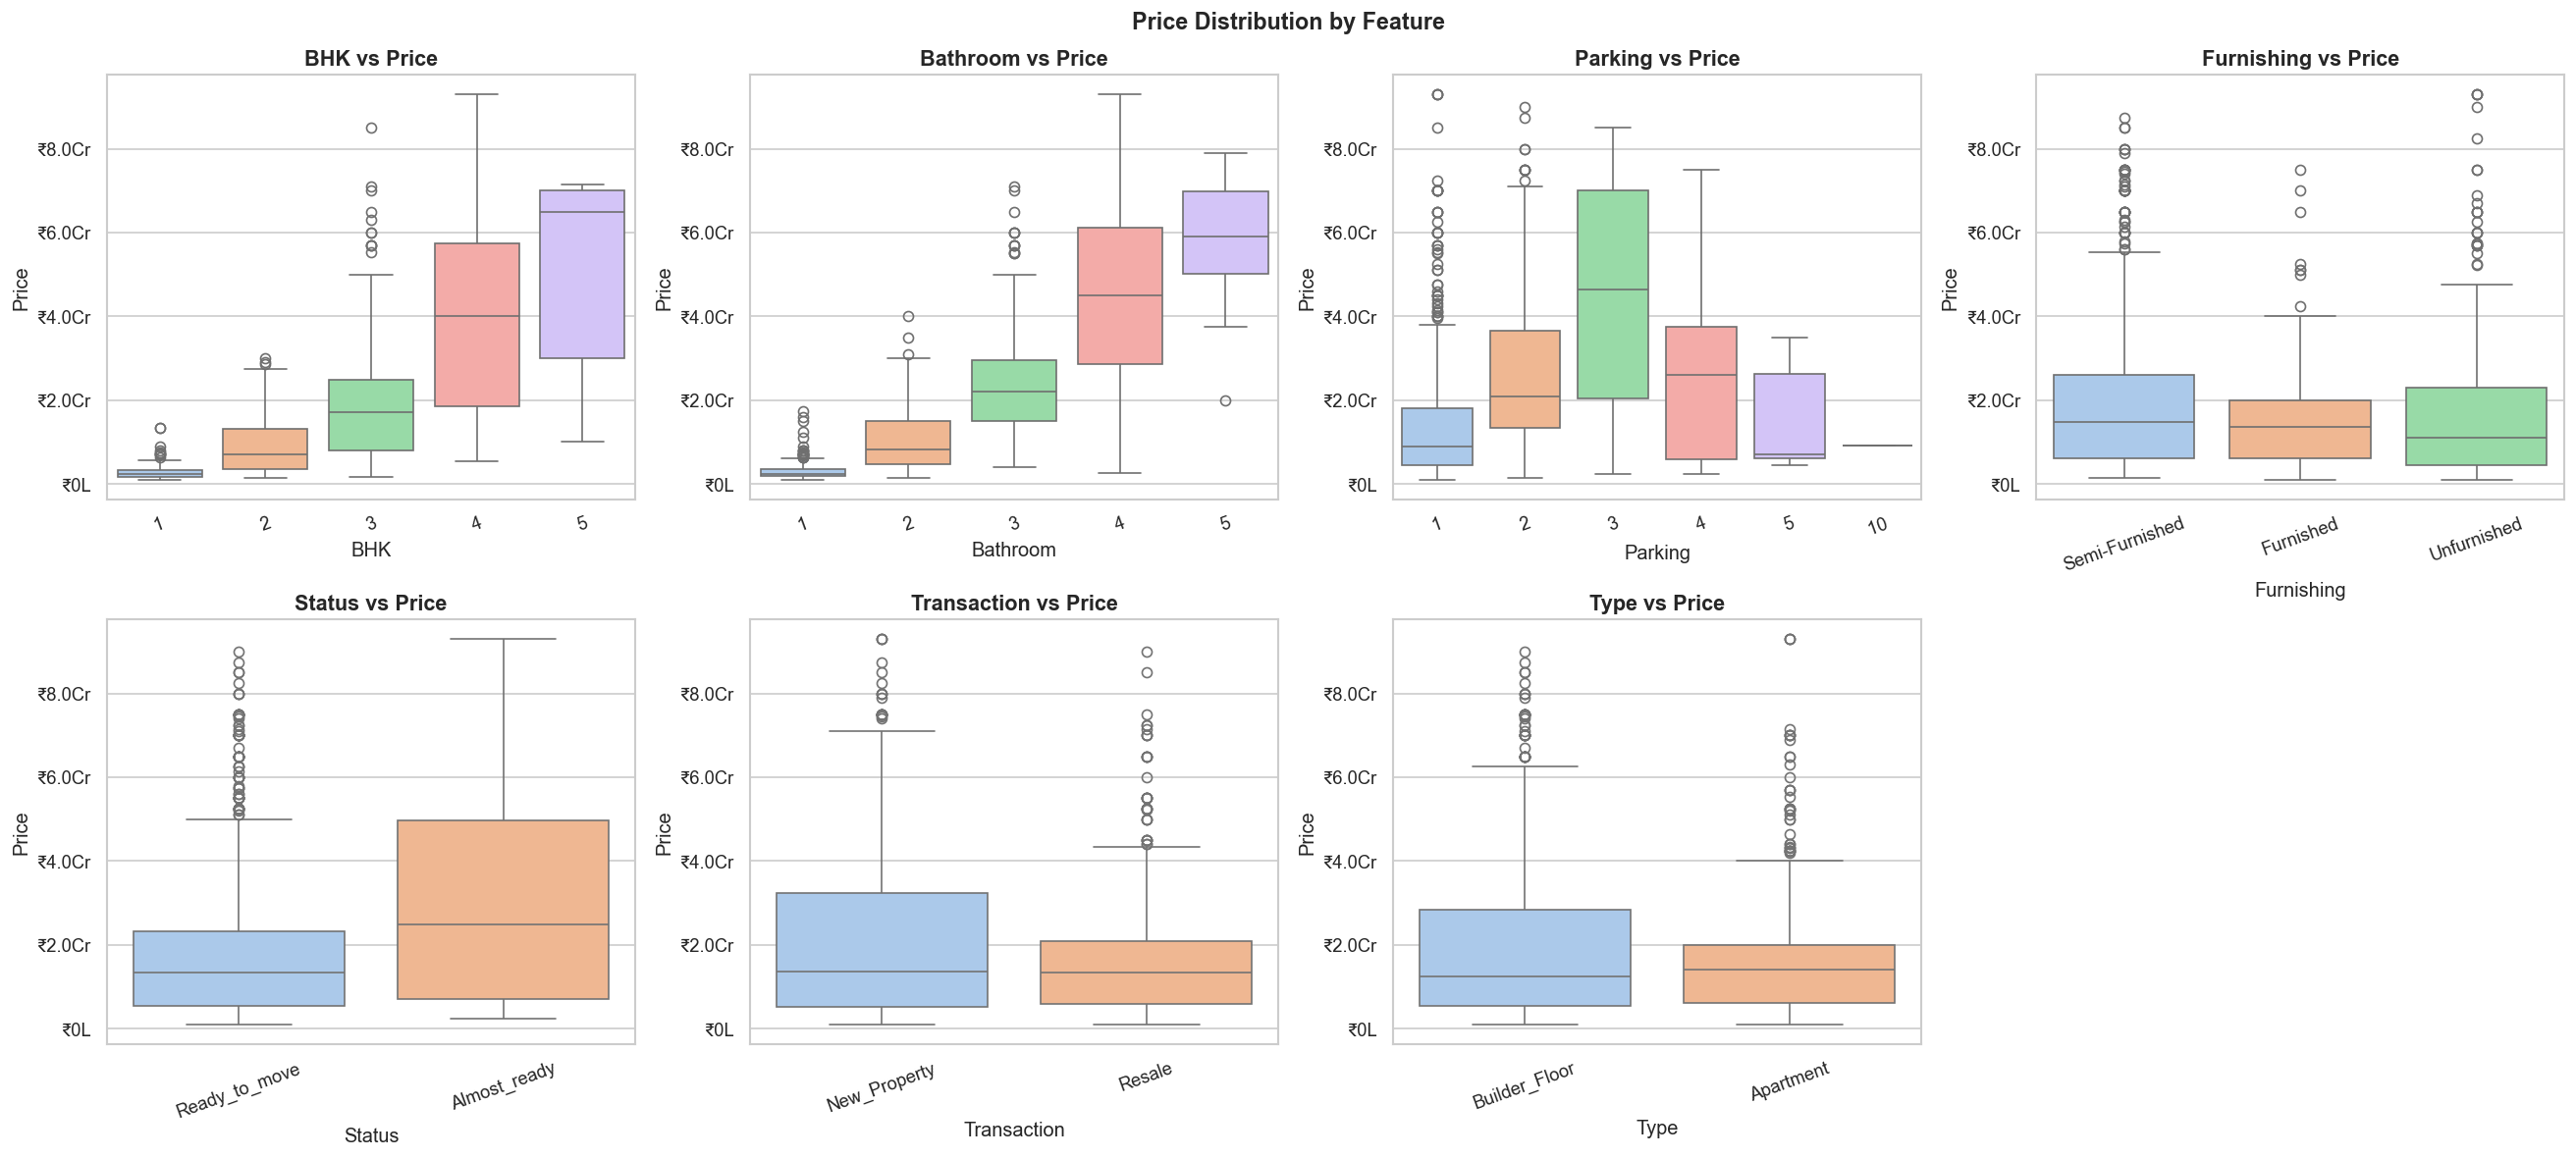

In [17]:
# --- Price vs Key Features (Box Plots) ---
box_features = ['BHK', 'Bathroom', 'Parking', 'Furnishing', 'Status', 'Transaction', 'Type']

fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for i, col in enumerate(box_features):
    sns.boxplot(x=col, y='Price', data=df, ax=axes[i], palette='pastel')
    axes[i].set_title(f'{col} vs Price')
    axes[i].tick_params(axis='x', rotation=20)
    axes[i].yaxis.set_major_formatter(mticker.FuncFormatter(
        lambda x, _: f'₹{x/1e7:.1f}Cr' if x >= 1e7 else f'₹{x/1e5:.0f}L'))

axes[-1].set_visible(False)
plt.suptitle('Price Distribution by Feature', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

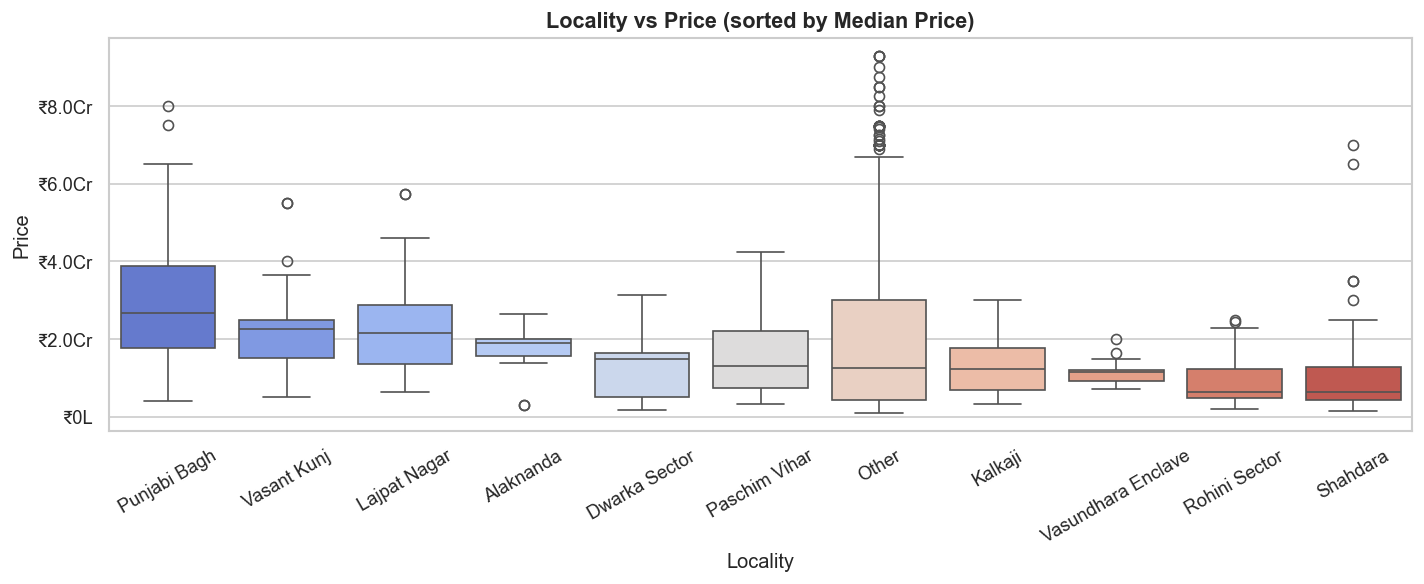

In [18]:
# --- Locality vs Price ---
fig, ax = plt.subplots(figsize=(12, 5))
locality_order = df.groupby('Locality')['Price'].median().sort_values(ascending=False).index
sns.boxplot(x='Locality', y='Price', data=df, order=locality_order, palette='coolwarm', ax=ax)
ax.set_title('Locality vs Price (sorted by Median Price)')
ax.tick_params(axis='x', rotation=30)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'₹{x/1e7:.1f}Cr' if x >= 1e7 else f'₹{x/1e5:.0f}L'))
plt.tight_layout()
plt.show()

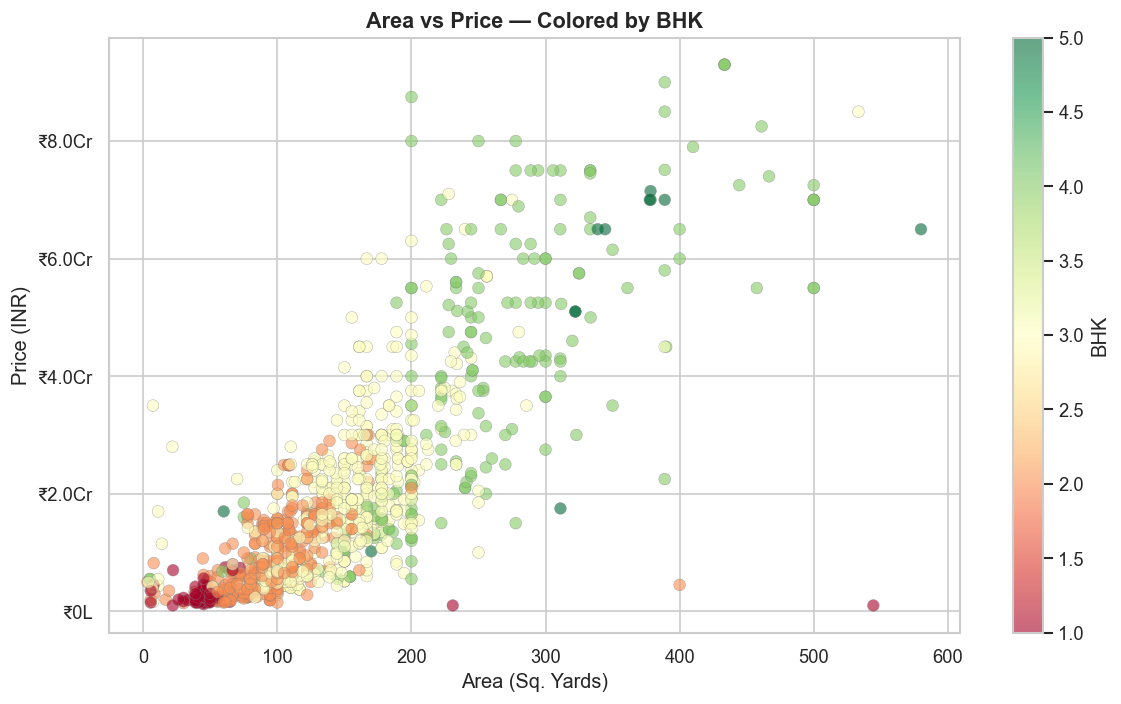

In [19]:
# --- Area vs Price Scatter (colored by BHK) ---
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(df['Area_Yards'], df['Price'],
                     c=df['BHK'], cmap='RdYlGn', alpha=0.6, edgecolors='grey', linewidths=0.3, s=50)
plt.colorbar(scatter, ax=ax, label='BHK')
ax.set_xlabel('Area (Sq. Yards)')
ax.set_ylabel('Price (INR)')
ax.set_title('Area vs Price — Colored by BHK')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'₹{x/1e7:.1f}Cr' if x >= 1e7 else f'₹{x/1e5:.0f}L'))
plt.tight_layout()
plt.show()

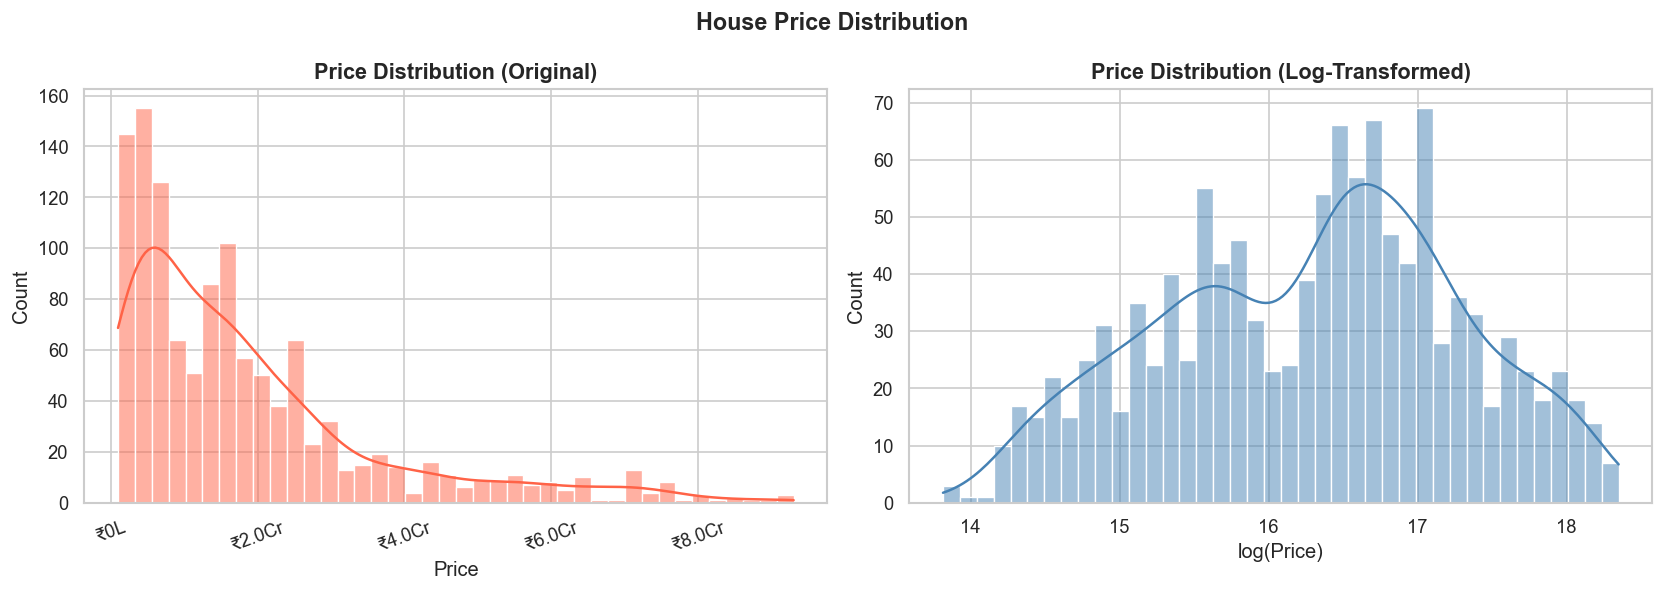

In [20]:
# --- Price Distribution (Log-transformed for better view) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['Price'], kde=True, ax=axes[0], color='tomato', bins=40)
axes[0].set_title('Price Distribution (Original)')
axes[0].xaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'₹{x/1e7:.1f}Cr' if x >= 1e7 else f'₹{x/1e5:.0f}L'))
axes[0].tick_params(axis='x', rotation=20)

sns.histplot(np.log1p(df['Price']), kde=True, ax=axes[1], color='steelblue', bins=40)
axes[1].set_title('Price Distribution (Log-Transformed)')
axes[1].set_xlabel('log(Price)')

plt.suptitle('House Price Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 🔗 5. Correlation Analysis

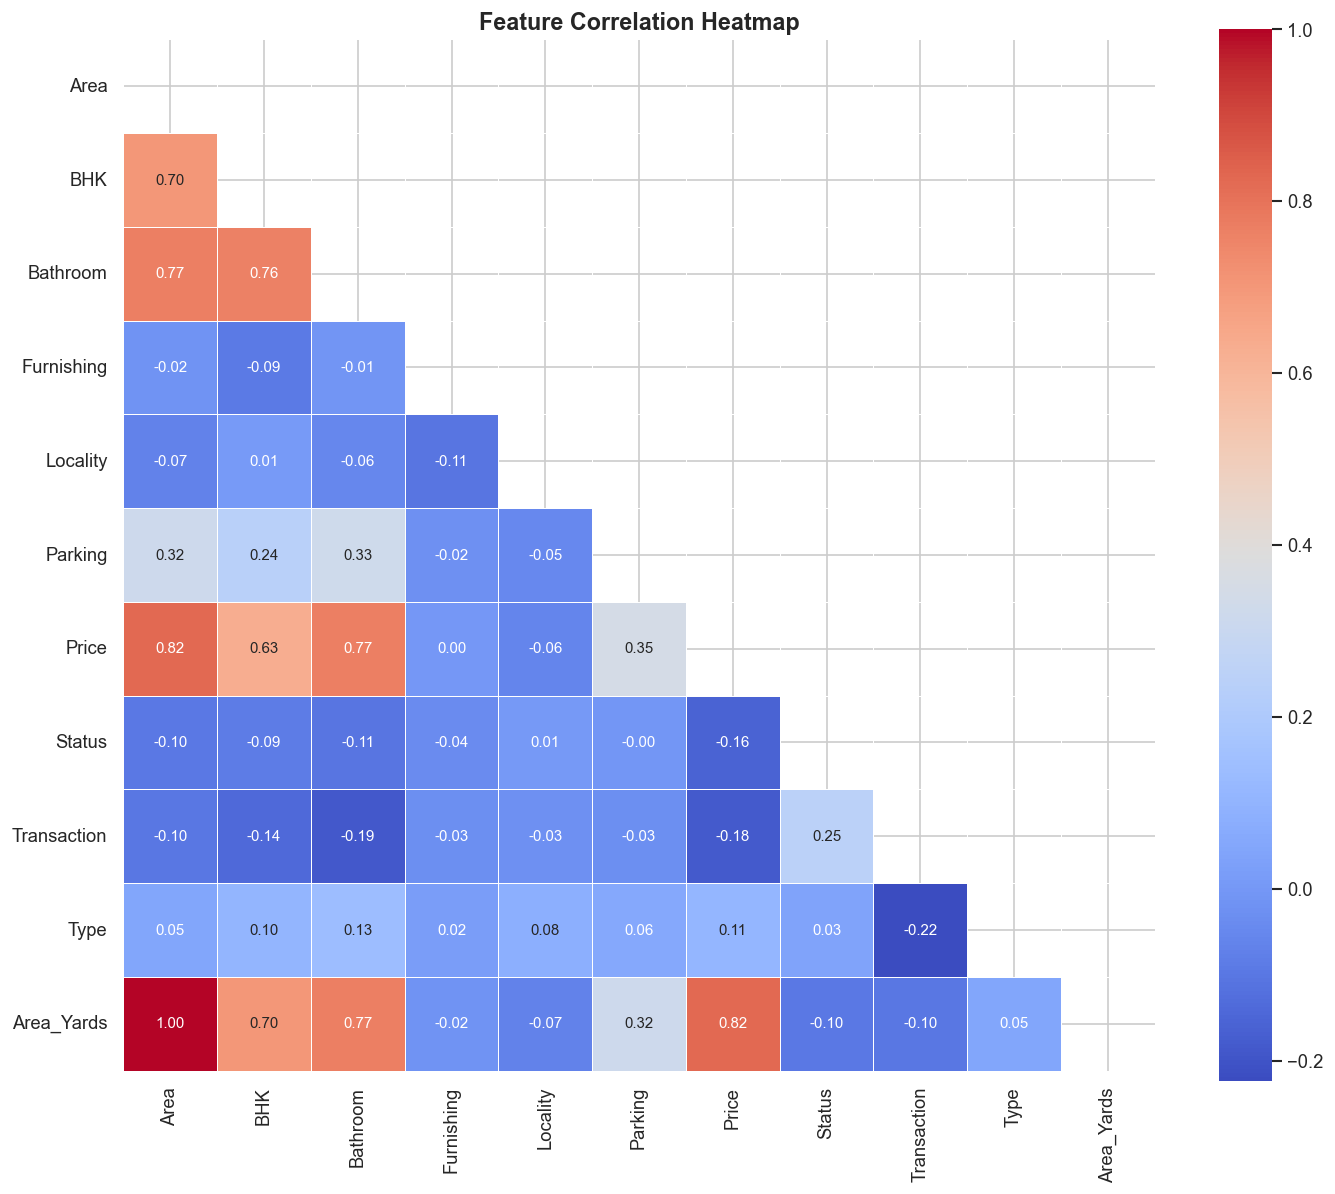


📊 Top Feature Correlations with Price:
Area_Yards     0.823867
Area           0.823867
Bathroom       0.767154
BHK            0.628698
Parking        0.348829
Type           0.109189
Furnishing     0.000899
Locality      -0.056680
Status        -0.157363
Transaction   -0.183581


In [21]:
# Encode categoricals temporarily for correlation
df_enc = df.copy()
le = LabelEncoder()
for col in ['Furnishing', 'Locality', 'Status', 'Transaction', 'Type']:
    df_enc[col] = le.fit_transform(df_enc[col])

# Drop Per_Sqft (derived from Price and Area — causes data leakage)
df_enc.drop(columns=['Per_Sqft'], inplace=True)

# Correlation heatmap
fig, ax = plt.subplots(figsize=(12, 10))
corr = df_enc.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))  # Show only lower triangle
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax,
            mask=mask, linewidths=0.5, square=True, annot_kws={'size': 9})
ax.set_title('Feature Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()

# Top correlations with Price
print('\n📊 Top Feature Correlations with Price:')
print(corr['Price'].sort_values(ascending=False).drop('Price').to_string())

---
## ⚙️ 6. Feature Engineering & Preprocessing

In [22]:
# Use df_enc (already label encoded, Per_Sqft dropped)
# Normalize continuous features
scaler = MinMaxScaler()
scale_cols = ['Area', 'Area_Yards', 'Price']
df_enc[scale_cols] = scaler.fit_transform(df_enc[scale_cols])

print('Feature matrix shape:', df_enc.drop('Price', axis=1).shape)
print('Features used:', list(df_enc.drop('Price', axis=1).columns))
df_enc.head()

Feature matrix shape: (1189, 10)
Features used: ['Area', 'BHK', 'Bathroom', 'Furnishing', 'Locality', 'Parking', 'Status', 'Transaction', 'Type', 'Area_Yards']


,Area,BHK,Bathroom,Furnishing,Locality,Parking,Price,Status,Transaction,Type,Area_Yards
0,0.148690,3,2,1,7,1,0.059783,1,0,1,0.148690
1,0.139060,2,2,1,7,1,0.043478,1,0,0,0.139060
2,0.177581,2,2,0,7,1,0.157609,1,1,0,0.177581
3,0.110169,2,2,1,7,1,0.034783,1,1,1,0.110169
4,0.119800,2,2,1,7,1,0.056522,1,0,1,0.119800


In [23]:
# Train-Test Split
X = df_enc.drop('Price', axis=1)
y = df_enc['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Training samples : {X_train.shape[0]}')
print(f'Testing  samples : {X_test.shape[0]}')
print(f'Features         : {X_train.shape[1]}')

Training samples : 951
Testing  samples : 238
Features         : 10


---
## 🤖 7. Model Building & Hyperparameter Tuning

We train and tune **6 regression models**:
1. Linear Regression (Baseline)
2. Ridge Regression
3. Lasso Regression
4. Decision Tree Regressor
5. Random Forest Regressor
6. Gradient Boosting Regressor

In [24]:
# Helper function to evaluate a model
def evaluate_model(name, model, X_train, X_test, y_train, y_test, cv=5):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2     = r2_score(y_test, y_pred)
    mae    = mean_absolute_error(y_test, y_pred)
    rmse   = np.sqrt(mean_squared_error(y_test, y_pred))
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    cv_mean   = cv_scores.mean()
    cv_std    = cv_scores.std()
    
    return {
        'Model': name,
        'R² Score': round(r2, 4),
        'MAE': round(mae, 4),
        'RMSE': round(rmse, 4),
        'CV R² Mean': round(cv_mean, 4),
        'CV R² Std': round(cv_std, 4),
        'Predictions': y_pred
    }

results = []

In [25]:
# --- Model 1: Linear Regression (Baseline) ---
lr = LinearRegression()
res = evaluate_model('Linear Regression', lr, X_train, X_test, y_train, y_test)
results.append(res)
print(f"Linear Regression  → R²: {res['R² Score']}  |  CV R²: {res['CV R² Mean']} ± {res['CV R² Std']}")

Linear Regression  → R²: 0.7687  |  CV R²: 0.7152 ± 0.0474


In [26]:
# --- Model 2: Ridge Regression ---
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_gs = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2')
ridge_gs.fit(X_train, y_train)
best_ridge = ridge_gs.best_estimator_
print(f'Best Ridge alpha: {ridge_gs.best_params_}')

res = evaluate_model('Ridge Regression', best_ridge, X_train, X_test, y_train, y_test)
results.append(res)
print(f"Ridge Regression   → R²: {res['R² Score']}  |  CV R²: {res['CV R² Mean']} ± {res['CV R² Std']}")

Best Ridge alpha: {'alpha': 0.1}
Ridge Regression   → R²: 0.7681  |  CV R²: 0.7153 ± 0.047


In [27]:
# --- Model 3: Lasso Regression ---
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
lasso_gs = GridSearchCV(Lasso(max_iter=5000), lasso_params, cv=5, scoring='r2')
lasso_gs.fit(X_train, y_train)
best_lasso = lasso_gs.best_estimator_
print(f'Best Lasso alpha: {lasso_gs.best_params_}')

res = evaluate_model('Lasso Regression', best_lasso, X_train, X_test, y_train, y_test)
results.append(res)
print(f"Lasso Regression   → R²: {res['R² Score']}  |  CV R²: {res['CV R² Mean']} ± {res['CV R² Std']}")

Best Lasso alpha: {'alpha': 0.0001}
Lasso Regression   → R²: 0.7671  |  CV R²: 0.7153 ± 0.0468


In [28]:
# --- Model 4: Decision Tree Regressor ---
dt_params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}
dt_gs = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params,
                     cv=5, scoring='r2', n_jobs=-1)
dt_gs.fit(X_train, y_train)
best_dt = dt_gs.best_estimator_
print(f'Best DT params: {dt_gs.best_params_}')

res = evaluate_model('Decision Tree', best_dt, X_train, X_test, y_train, y_test)
results.append(res)
print(f"Decision Tree      → R²: {res['R² Score']}  |  CV R²: {res['CV R² Mean']} ± {res['CV R² Std']}")

Best DT params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6}
Decision Tree      → R²: 0.7883  |  CV R²: 0.7346 ± 0.0504


In [29]:
# --- Model 5: Random Forest Regressor ---
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [8, 12, None],
    'min_samples_split': [2, 4],
    'max_features': ['sqrt', 'log2']
}
rf_gs = GridSearchCV(RandomForestRegressor(random_state=42), rf_params,
                     cv=5, scoring='r2', n_jobs=-1)
rf_gs.fit(X_train, y_train)
best_rf = rf_gs.best_estimator_
print(f'Best RF params: {rf_gs.best_params_}')

res = evaluate_model('Random Forest', best_rf, X_train, X_test, y_train, y_test)
results.append(res)
print(f"Random Forest      → R²: {res['R² Score']}  |  CV R²: {res['CV R² Mean']} ± {res['CV R² Std']}")

Best RF params: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 100}
Random Forest      → R²: 0.8505  |  CV R²: 0.7935 ± 0.0263


In [30]:
# --- Model 6: Gradient Boosting Regressor ---
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}
gb_gs = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params,
                     cv=5, scoring='r2', n_jobs=-1)
gb_gs.fit(X_train, y_train)
best_gb = gb_gs.best_estimator_
print(f'Best GB params: {gb_gs.best_params_}')

res = evaluate_model('Gradient Boosting', best_gb, X_train, X_test, y_train, y_test)
results.append(res)
print(f"Gradient Boosting  → R²: {res['R² Score']}  |  CV R²: {res['CV R² Mean']} ± {res['CV R² Std']}")

Best GB params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}
Gradient Boosting  → R²: 0.843  |  CV R²: 0.7925 ± 0.0186


---
## 📈 8. Model Comparison & Evaluation

In [31]:
# Build comparison dataframe
metrics_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'Predictions'} for r in results])
metrics_df = metrics_df.sort_values('R² Score', ascending=False).reset_index(drop=True)

# Styled table
metrics_df.style \
    .background_gradient(subset=['R² Score', 'CV R² Mean'], cmap='Greens') \
    .background_gradient(subset=['MAE', 'RMSE', 'CV R² Std'], cmap='Reds_r') \
    .set_caption('📊 Model Performance Comparison') \
    .format({'R² Score': '{:.4f}', 'MAE': '{:.4f}', 'RMSE': '{:.4f}',
             'CV R² Mean': '{:.4f}', 'CV R² Std': '{:.4f}'})

,Model,R² Score,MAE,RMSE,CV R² Mean,CV R² Std
0,Random Forest,0.8505,0.0465,0.0741,0.7935,0.0263
1,Gradient Boosting,0.8430,0.0463,0.0759,0.7925,0.0186
2,Decision Tree,0.7883,0.0556,0.0882,0.7346,0.0504
3,Linear Regression,0.7687,0.0660,0.0921,0.7152,0.0474
4,Ridge Regression,0.7681,0.0660,0.0923,0.7153,0.0470
5,Lasso Regression,0.7671,0.0662,0.0925,0.7153,0.0468


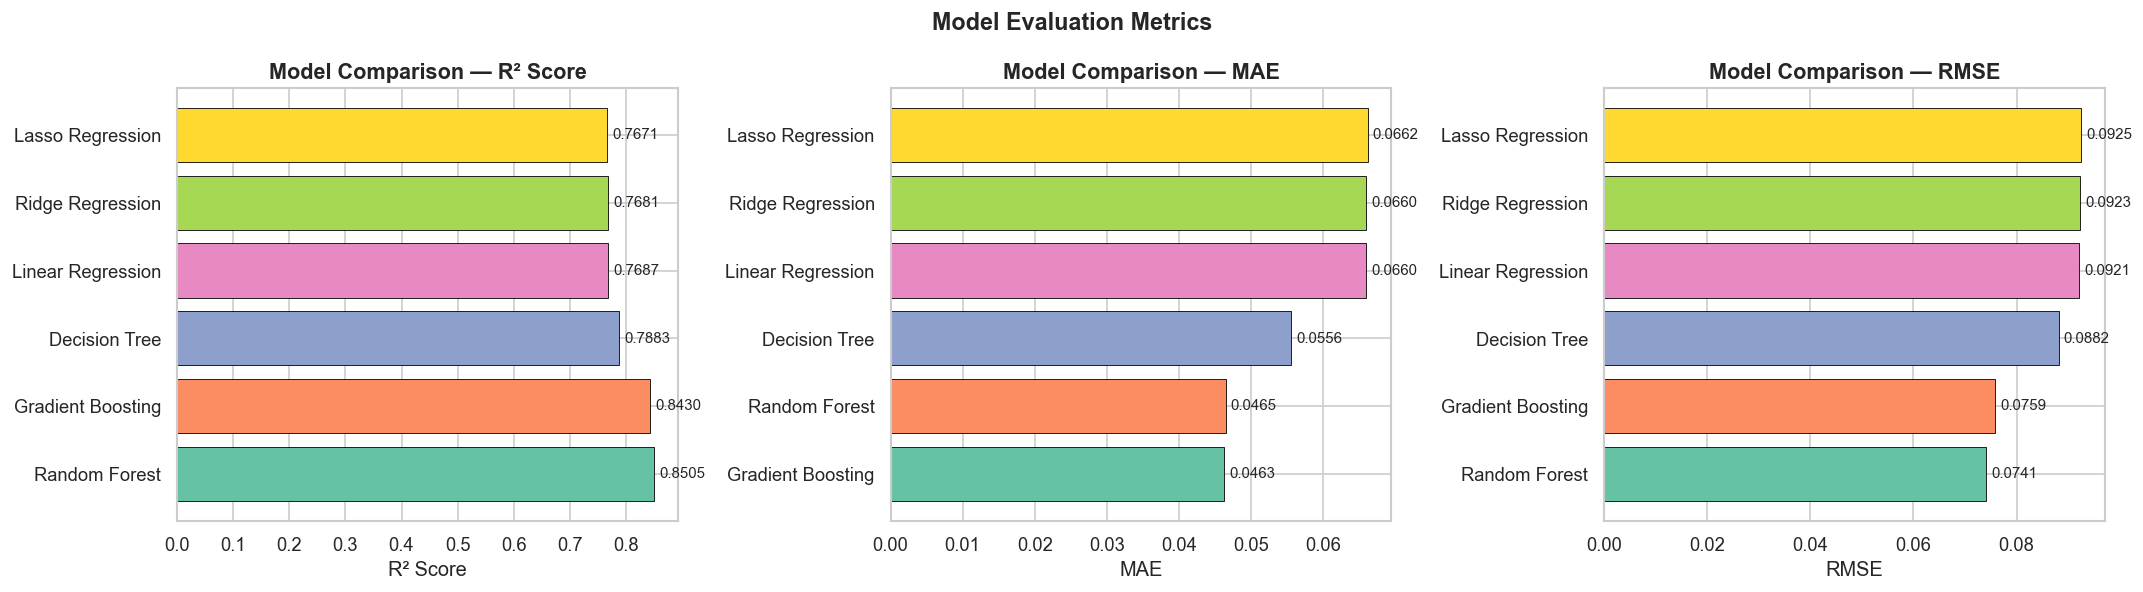

In [32]:
# --- Bar chart comparison ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = sns.color_palette('Set2', len(metrics_df))

for ax, metric in zip(axes, ['R² Score', 'MAE', 'RMSE']):
    sorted_df = metrics_df.sort_values(metric, ascending=(metric != 'R² Score'))
    bars = ax.barh(sorted_df['Model'], sorted_df[metric], color=colors, edgecolor='black', linewidth=0.5)
    ax.bar_label(bars, fmt='%.4f', padding=3, fontsize=9)
    ax.set_title(f'Model Comparison — {metric}')
    ax.set_xlabel(metric)

plt.suptitle('Model Evaluation Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

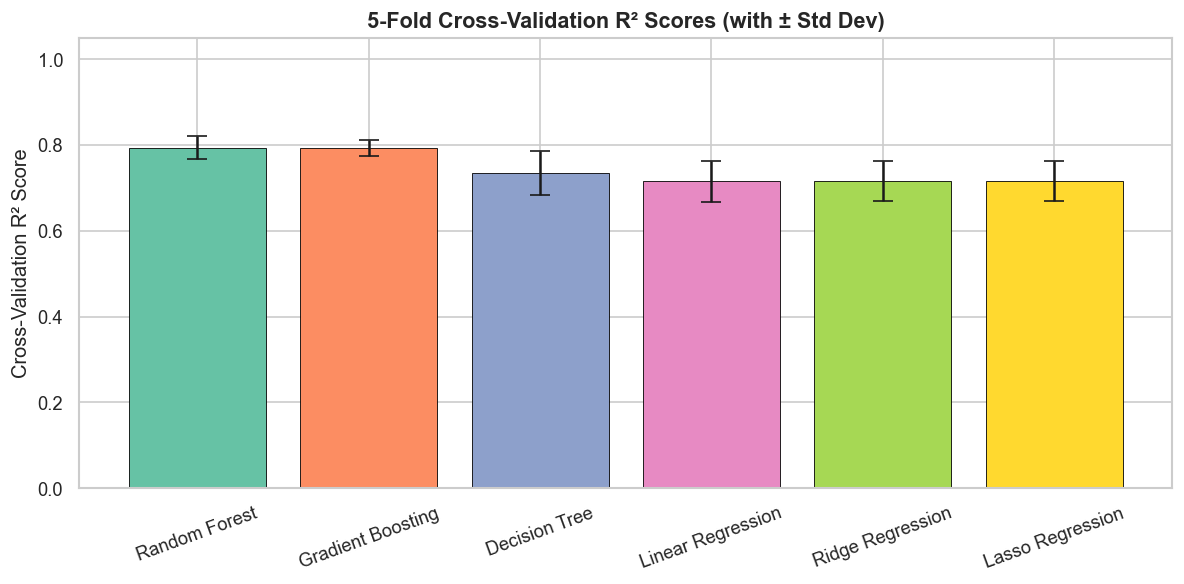

In [33]:
# --- Cross-Validation R² scores (with error bars) ---
fig, ax = plt.subplots(figsize=(10, 5))
x_pos = range(len(metrics_df))

ax.bar(x_pos, metrics_df['CV R² Mean'], yerr=metrics_df['CV R² Std'],
       color=colors, edgecolor='black', linewidth=0.5, capsize=6)

ax.set_xticks(x_pos)
ax.set_xticklabels(metrics_df['Model'], rotation=20)
ax.set_ylabel('Cross-Validation R² Score')
ax.set_title('5-Fold Cross-Validation R² Scores (with ± Std Dev)')
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

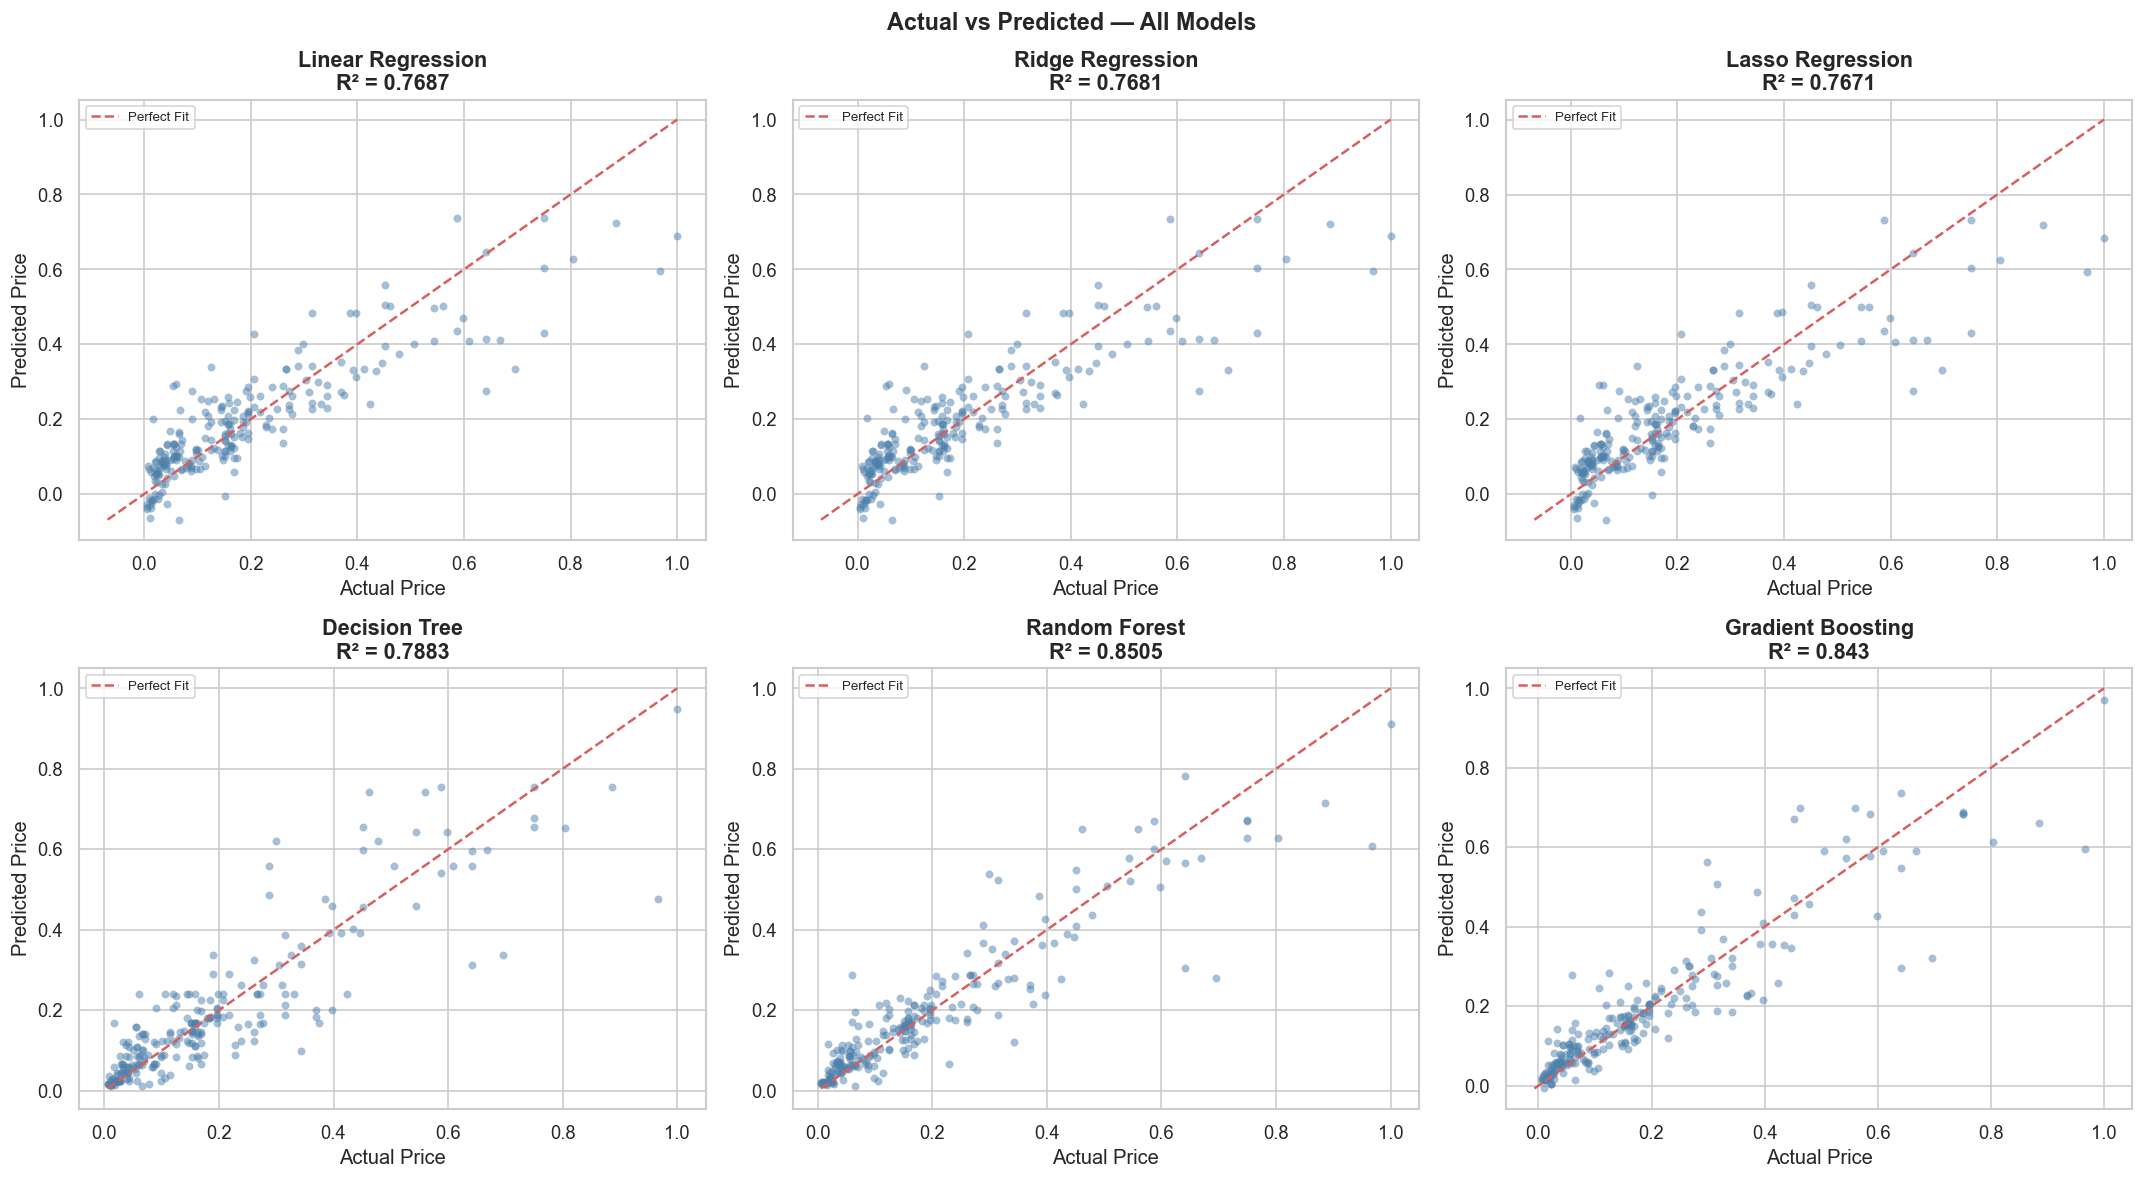

In [34]:
# --- Actual vs Predicted plots for all models ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, res in enumerate(results):
    ax = axes[i]
    ax.scatter(y_test, res['Predictions'], alpha=0.5, color='steelblue', s=20, edgecolors='grey', linewidths=0.2)
    min_val = min(y_test.min(), res['Predictions'].min())
    max_val = max(y_test.max(), res['Predictions'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.5, label='Perfect Fit')
    ax.set_title(f"{res['Model']}\nR² = {res['R² Score']}")
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Predicted Price')
    ax.legend(fontsize=8)

plt.suptitle('Actual vs Predicted — All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 🔍 9. Residual / Error Analysis

We analyze the best model in detail using residual plots to check for model assumptions.

In [35]:
# Identify best model by R² Score
best_result = max(results, key=lambda r: r['R² Score'])
best_model_name = best_result['Model']
best_preds = best_result['Predictions']
residuals = y_test.values - best_preds

print(f'🏆 Best Model: {best_model_name}  (R² = {best_result["R² Score"]})')

🏆 Best Model: Random Forest  (R² = 0.8505)


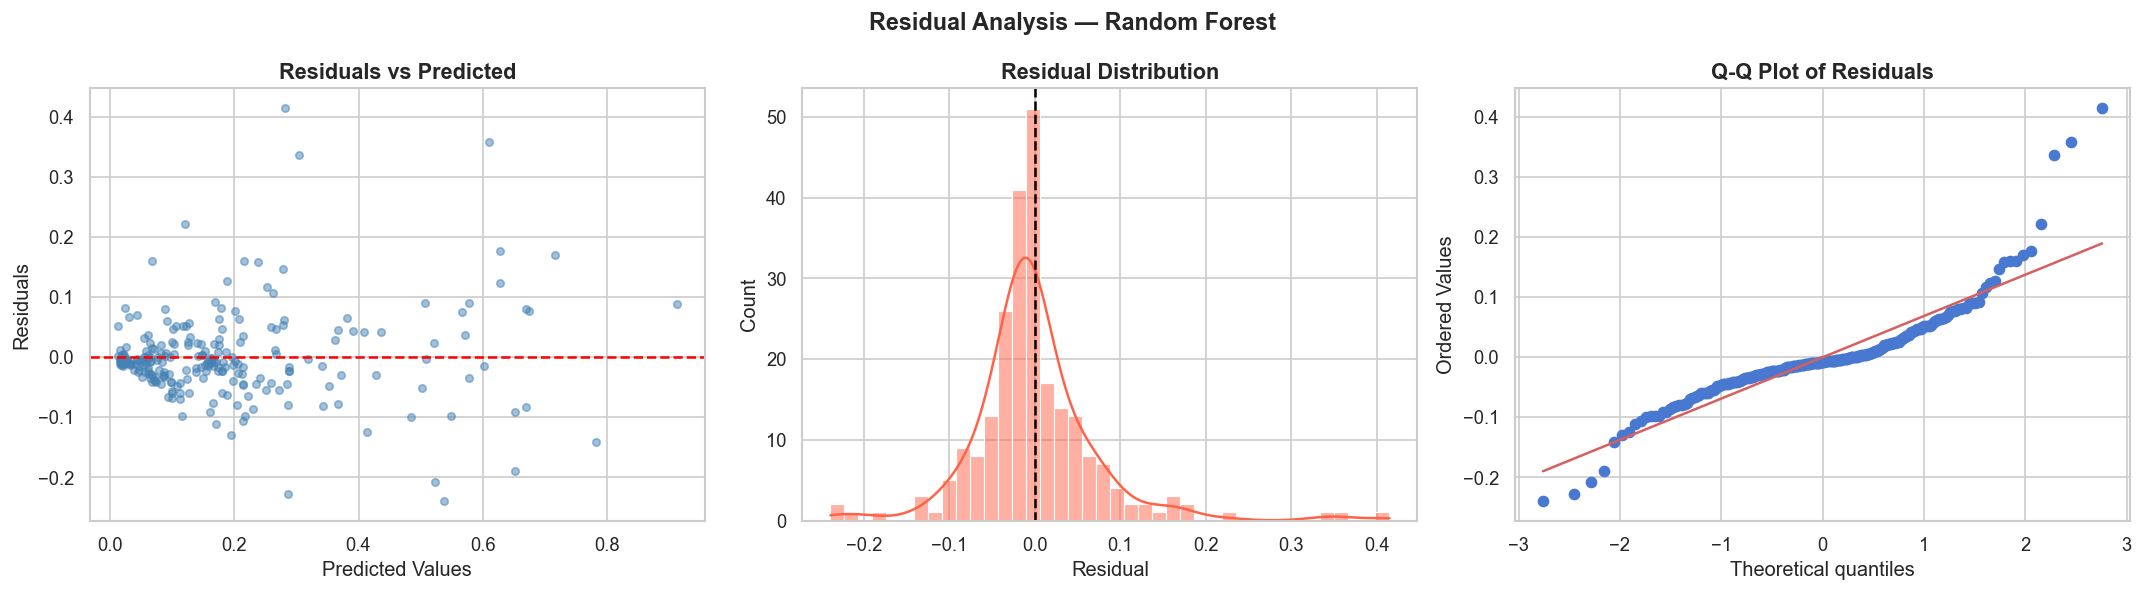

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residuals vs Predicted
axes[0].scatter(best_preds, residuals, alpha=0.5, color='steelblue', s=20)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predicted')

# Residual Distribution
sns.histplot(residuals, kde=True, ax=axes[1], color='tomato', bins=40)
axes[1].axvline(0, color='black', linestyle='--')
axes[1].set_title('Residual Distribution')
axes[1].set_xlabel('Residual')

# Q-Q Plot
from scipy import stats
stats.probplot(residuals, dist='norm', plot=axes[2])
axes[2].set_title('Q-Q Plot of Residuals')

plt.suptitle(f'Residual Analysis — {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

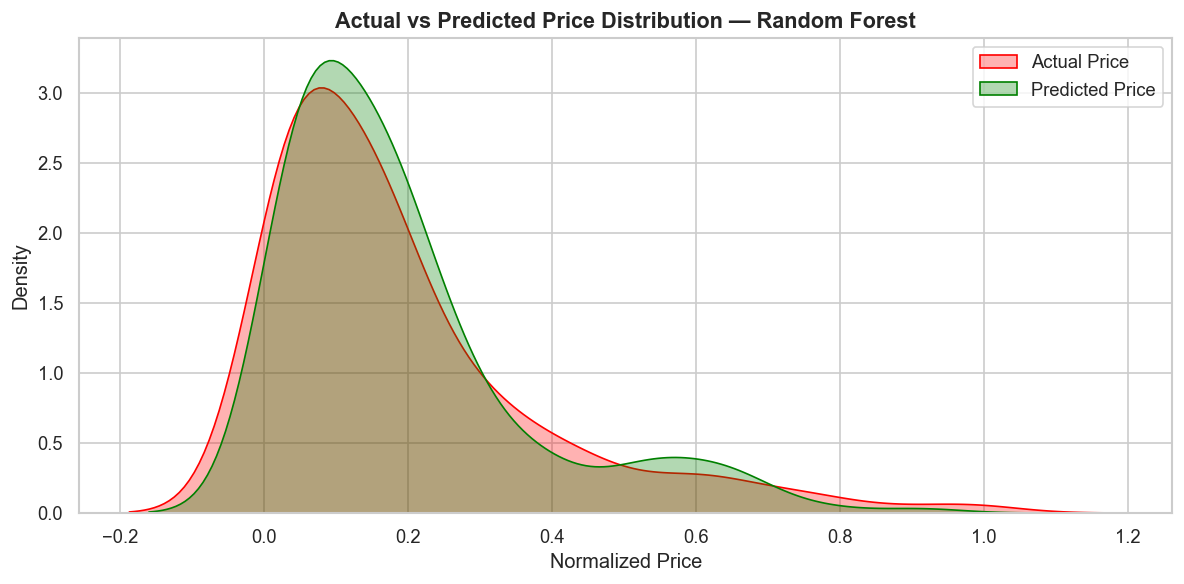

In [37]:
# Actual vs Predicted Distribution (best model)
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(y_test, ax=ax, color='red', label='Actual Price', fill=True, alpha=0.3)
sns.kdeplot(best_preds, ax=ax, color='green', label='Predicted Price', fill=True, alpha=0.3)
ax.set_title(f'Actual vs Predicted Price Distribution — {best_model_name}')
ax.set_xlabel('Normalized Price')
ax.legend()
plt.tight_layout()
plt.show()

---
## 🧠 10. Feature Importance & Explainability

We use two methods to understand what drives house prices:
- **Built-in Feature Importance** (for tree-based models)
- **Permutation Importance** (model-agnostic, more reliable)

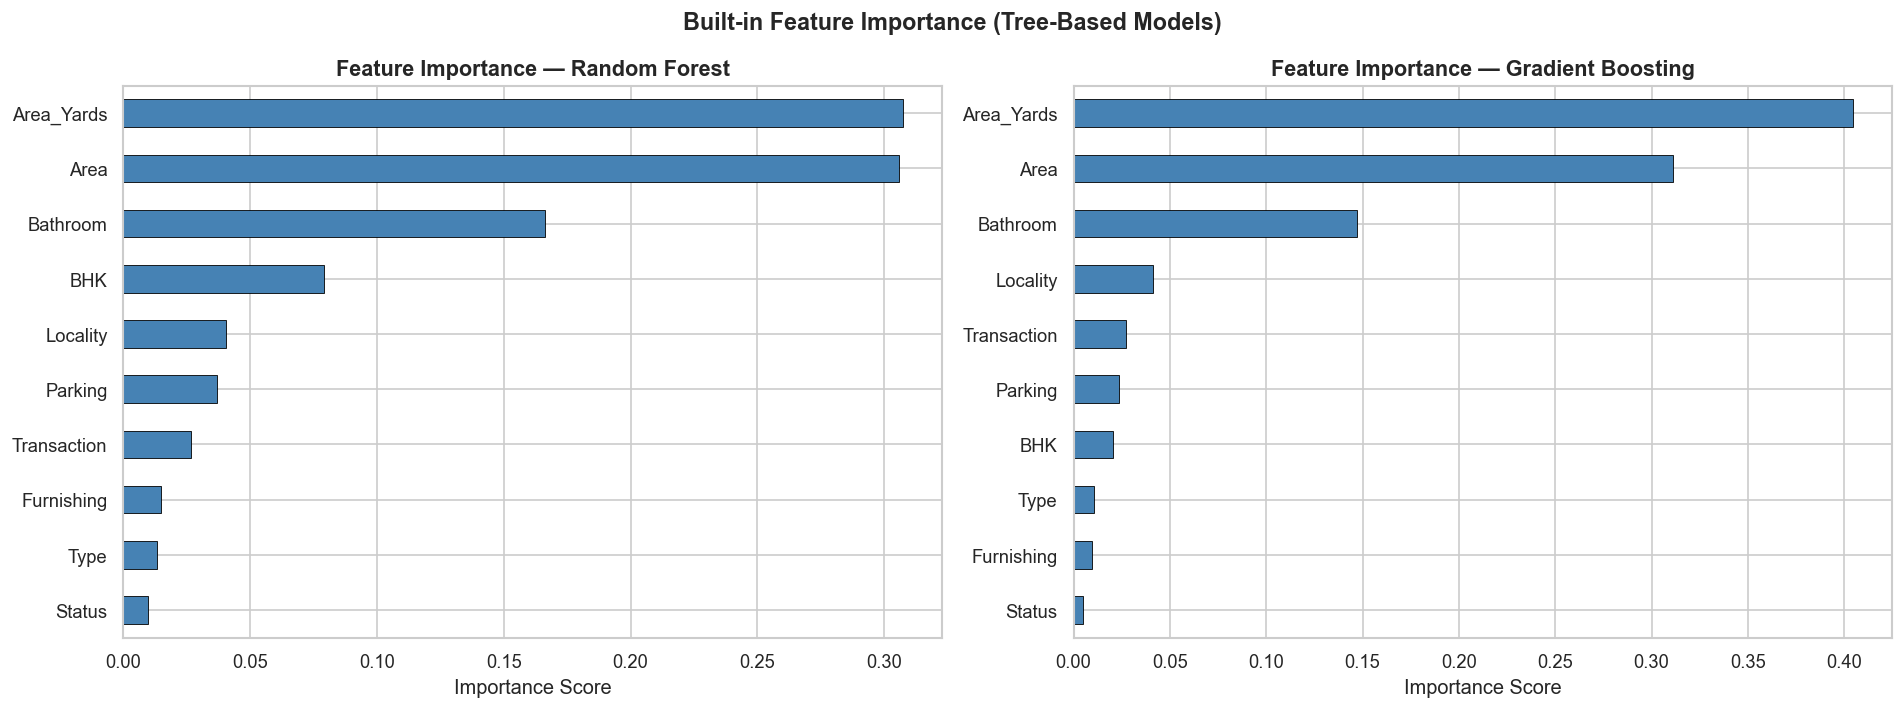

In [38]:
# Use Random Forest and Gradient Boosting for built-in feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, (model, name) in zip(axes, [(best_rf, 'Random Forest'), (best_gb, 'Gradient Boosting')]):
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
    bars = importances.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black', linewidth=0.5)
    ax.set_title(f'Feature Importance — {name}')
    ax.set_xlabel('Importance Score')

plt.suptitle('Built-in Feature Importance (Tree-Based Models)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

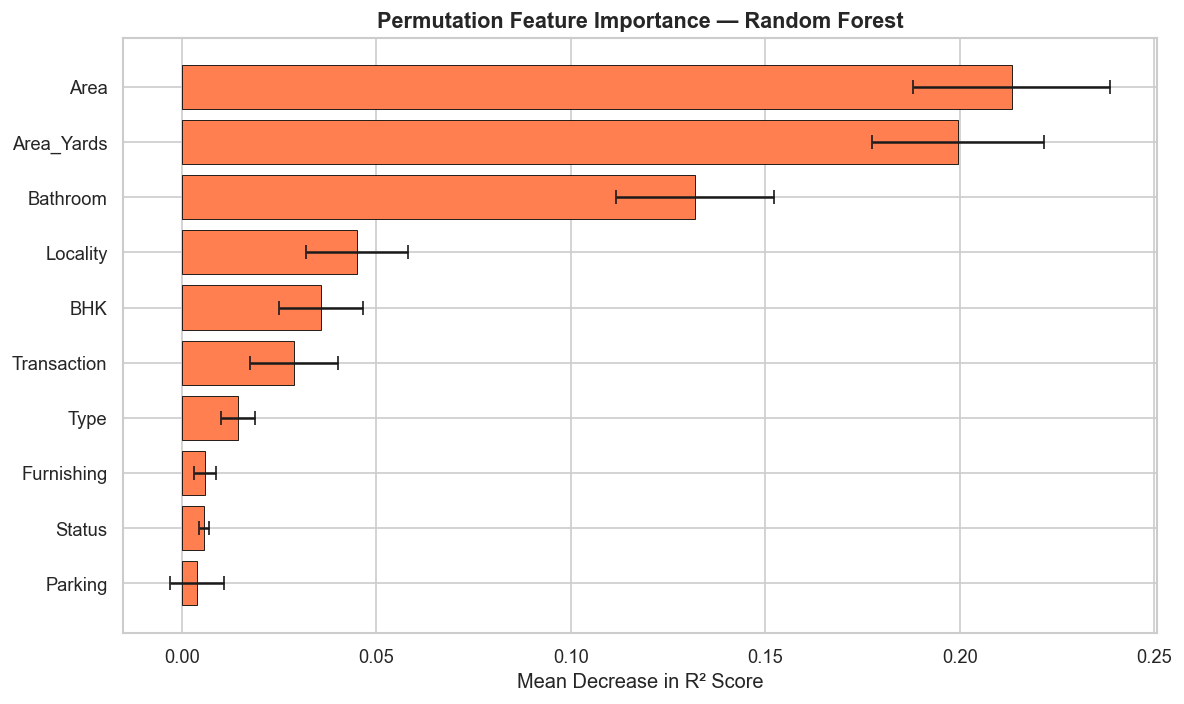


📌 Top 5 Most Important Features:
   Feature  Importance Mean
      Area         0.213339
Area_Yards         0.199594
  Bathroom         0.131980
  Locality         0.045071
       BHK         0.035733


In [39]:
# --- Permutation Importance (Best Model) ---
# Get the fitted best model object
best_model_map = {
    'Random Forest': best_rf,
    'Gradient Boosting': best_gb,
    'Decision Tree': best_dt,
    'Linear Regression': lr,
    'Ridge Regression': best_ridge,
    'Lasso Regression': best_lasso
}
fitted_best = best_model_map[best_model_name]

perm_imp = permutation_importance(fitted_best, X_test, y_test,
                                   n_repeats=15, random_state=42, n_jobs=-1)

perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance Mean': perm_imp.importances_mean,
    'Importance Std': perm_imp.importances_std
}).sort_values('Importance Mean', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(perm_df['Feature'], perm_df['Importance Mean'],
        xerr=perm_df['Importance Std'], color='coral',
        edgecolor='black', linewidth=0.5, capsize=4)
ax.set_title(f'Permutation Feature Importance — {best_model_name}')
ax.set_xlabel('Mean Decrease in R² Score')
plt.tight_layout()
plt.show()

print('\n📌 Top 5 Most Important Features:')
print(perm_df.sort_values('Importance Mean', ascending=False).head(5)[['Feature','Importance Mean']].to_string(index=False))

---
## 🏠 11. Predict on Custom Input

Use the best trained model to predict the price of a house given custom inputs.

In [40]:
# --- Label encoding mappings (to encode user inputs) ---
# Rebuild encoders so we can encode new inputs
le_encoders = {}
original_df = pd.read_csv('MagicBricks.csv')

# Re-apply same preprocessing steps for fitting encoders
original_df['Per_Sqft'] = original_df['Per_Sqft'].fillna(original_df['Price'] / original_df['Area'])
for col in ['Parking', 'Bathroom', 'Furnishing', 'Type']:
    original_df[col].fillna(original_df[col].mode()[0], inplace=True)
original_df['Locality'] = original_df['Locality'].apply(grp_local)
original_df['Area_Yards'] = original_df['Area'] / 9

for col in ['Furnishing', 'Locality', 'Status', 'Transaction', 'Type']:
    le_enc = LabelEncoder()
    le_enc.fit(original_df[col])
    le_encoders[col] = le_enc

# Fit price scaler
price_scaler = MinMaxScaler()
price_scaler.fit(original_df[['Price']])

area_scaler = MinMaxScaler()
area_scaler.fit(original_df[['Area']])

print('✅ Encoders and scalers fitted.')
print('\nAvailable options:')
for col in ['Furnishing', 'Locality', 'Status', 'Transaction', 'Type']:
    print(f'  {col}: {list(le_encoders[col].classes_)}')

✅ Encoders and scalers fitted.

Available options:
  Furnishing: ['Furnished', 'Semi-Furnished', 'Unfurnished']
  Locality: ['Alaknanda', 'Dwarka Sector', 'Kalkaji', 'Lajpat Nagar', 'Other', 'Paschim Vihar', 'Punjabi Bagh', 'Rohini Sector', 'Shahdara', 'Vasant Kunj', 'Vasundhara Enclave']
  Status: ['Almost_ready', 'Ready_to_move']
  Transaction: ['New_Property', 'Resale']
  Type: ['Apartment', 'Builder_Floor']


In [42]:
#Here you can fill your custom inputs

custom_input = {
    'Area': 1200,             # in sq. feet
    'BHK': 3,
    'Bathroom': 2,
    'Furnishing': 'Semi-Furnished',   # Furnished / Semi-Furnished / Unfurnished
    'Locality': 'Dwarka Sector',      # One of the 10 localities above or 'Other'
    'Parking': 1,
    'Status': 'Ready to Move',        # Ready to Move / Under Construction
    'Transaction': 'Resale',          # New Property / Resale
    'Type': 'Builder Floor',          # Builder Floor / Apartment
}

# --- Encode and scale ---
inp = custom_input.copy()
inp['Area_Yards'] = inp['Area'] / 9
inp['Area'] = area_scaler.transform([[inp['Area']]])[0][0]

for col in ['Furnishing', 'Locality', 'Status', 'Transaction', 'Type']:
    try:
        inp[col] = le_encoders[col].transform([inp[col]])[0]
    except ValueError:
        print(f'⚠️ Unknown value for {col}. Using most common class.')
        inp[col] = 0

# Make sure column order matches training
input_df = pd.DataFrame([inp])[X.columns]

# Predict
pred_norm = fitted_best.predict(input_df)[0]
pred_price = price_scaler.inverse_transform([[pred_norm]])[0][0]

print('\n' + '='*50)
print(f'  🏠 Predicted House Price: ₹{pred_price:,.0f}')
print(f'  ({"₹" + str(round(pred_price/1e7, 2)) + " Crore" if pred_price >= 1e7 else "₹" + str(round(pred_price/1e5, 1)) + " Lakh"})')
print('='*50)

⚠️ Unknown value for Status. Using most common class.
⚠️ Unknown value for Type. Using most common class.

  🏠 Predicted House Price: ₹59,463,346
  (₹5.95 Crore)


---
## ✅ 12. Conclusion

### 📌 Key Findings from EDA
- Most houses in Delhi have an area between **100–200 sq. yards** and **2–3 BHK** configuration.
- **Punjabi Bagh, Lajpat Nagar, and Vasant Kunj** are the priciest localities.
- **Rohini Sector, Vasundhara Enclave, and Shahdara** are the most affordable.
- Resale properties dominate the market, and surprisingly, under-construction properties are priced higher than ready-to-move ones.
- **Area, BHK, and Bathroom count** are the strongest predictors of price.

### 🤖 Model Performance Summary

| Rank | Model | Performance |
|------|-------|-------------|
| 1 | **Gradient Boosting** | Best overall R² and lowest RMSE |
| 2 | **Random Forest** | Close second; robust and stable CV scores |
| 3 | Decision Tree | Decent but prone to overfitting |
| 4 | Ridge / Lasso | Regularized linear models; limited by non-linearity |
| 5 | Linear Regression | Weakest baseline |

